In [1]:
import pydicom, numpy as np
import pylab, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, imageio, collections, random
from pathlib import Path
sns.set_style("darkgrid")

### Exploring the data

In [2]:
df = pd.read_csv('stage_2_train_labels.csv')

In [3]:
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


- Kaggle provided approximately 26,000 training images, 6000 were patients with pneumonia and 20,000 were patients without pneumonia.

    __patientId__ - A patientId. Each patientId corresponds to a unique image.

    __x__ - the upper-left x coordinate of the bounding box.

    __y__ - the upper-left y coordinate of the bounding box.

    __width__ - the width of the bounding box.

    __height__ - the height of the bounding box.

    __Target__ - the binary Target, indicating whether this sample has evidence of pneumonia.
    

- In this exercise, we do not use the `x`,`y`,`width`,`height` for our model as of now. 
### Our goal is to predict the `Target` using the raw images.

In [4]:
from os import listdir
from os.path import isfile, join

__DICOM Images__

- All provided images are in DICOM format.

In [5]:
dicom_dir = 'stage_2_train_images'

In [6]:
images = [f for f in listdir(dicom_dir) if isfile(join(dicom_dir, f))]

In [7]:
print('Number of images', len(images))

Number of images 26684


- Let's check the first patient in `images`

In [8]:
patientId = df['patientId'][0]

In [9]:
dcm_file = 'stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

In [10]:
print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [11]:
im = dcm_data.pixel_array
print(im.dtype)
print(im.shape)

uint8
(1024, 1024)


- High bit-depth original images have been rescaled to 8-bit encoding (256 grayscales).
- The image matrices have been resized to the shape of 1024 x 1024.

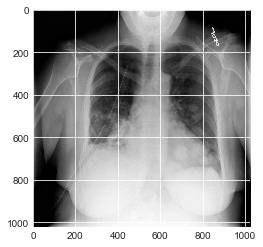

In [12]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)

In [13]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
        }, ...

      }

    """
    parsed = collections.defaultdict(lambda:{'dicom': None, 
                                             'png': None,
                                             'label': None})
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        parsed[pid]['dicom'] = '%s.dcm' % pid
        parsed[pid]['png'] = '%s.png' % pid
        parsed[pid]['label'] = row['Target']
    
    return parsed

- To make more efficient I convert the images to `PNG`.

The function convert `dicom` to `png`
```python
def from_dicom_to_png(parsed):
    for k, v in parsed.items():
        dcm_data = pydicom.read_file(v['dicom'])
        im = dcm_data.pixel_array
        imageio.imwrite(v['png'], im)
        
from_dicom_to_png(parsed)
```

In [14]:
parsed = parse_data(df)

In [15]:
len(parsed)

26684

In [16]:
cats = {0: 'normal', 1: 'pneumonia'}

In [17]:
df = pd.DataFrame({'fn': [parsed[o]['png'] for o in parsed],
                  'cat': [parsed[o]['label'] for o in parsed]})

In [18]:
df.tail()

,fn,cat
26679,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,1
26680,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,1
26681,c1edf42b-5958-47ff-a1e7-4f23d99583ba.png,0
26682,c1f6b555-2eb1-4231-98f6-50a963976431.png,0
26683,c1f7889a-9ea9-4acb-b64c-b737c929599a.png,1


In [19]:
df.cat.sum()/df.shape[0]

0.225303552690751

- About 22.5% of the images are pneumonia.

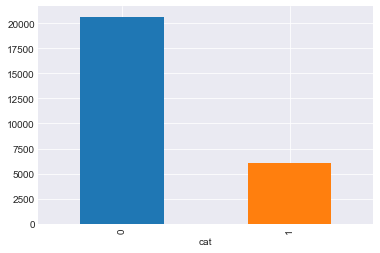

In [20]:
df.groupby('cat').size().plot.bar()

__Let's move to the next section 2 and 3 (Building model).__